<a href="https://colab.research.google.com/github/sadirs/Emulador_Distancias/blob/main/emulator_distances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook to Emulate comoving distance, luminosity distance and angular distance.

An emulator refers to a computational tool designed to replicate the behavior of a more complex and computationally expensive model. Emulators are used to approximate the output of these complex models with much lower computational cost.

Here are some key points about emulators:

- **Efficiency:** Emulators provide a way to perform quick approximations of model outputs, which is especially useful when dealing with large datasets or when performing extensive parameter studies.

- **Training:** Emulators are typically trained on a set of inputs and outputs from the full, complex model. Machine learning techniques, such as Gaussian processes or neural networks, are often used to create these emulators.

- **Applications:** In cosmology, emulators can be used to predict various observables, such as distances, power spectra, correlations function, or other quantities of interest, without running the full computational model each time.

- **Accuracy:** While emulators are approximations, they can be highly accurate if trained properly. The trade-off between accuracy and computational efficiency is a key consideration in their development.

- **Versatility:** Emulators can be applied to a wide range of models and problems beyond cosmology.



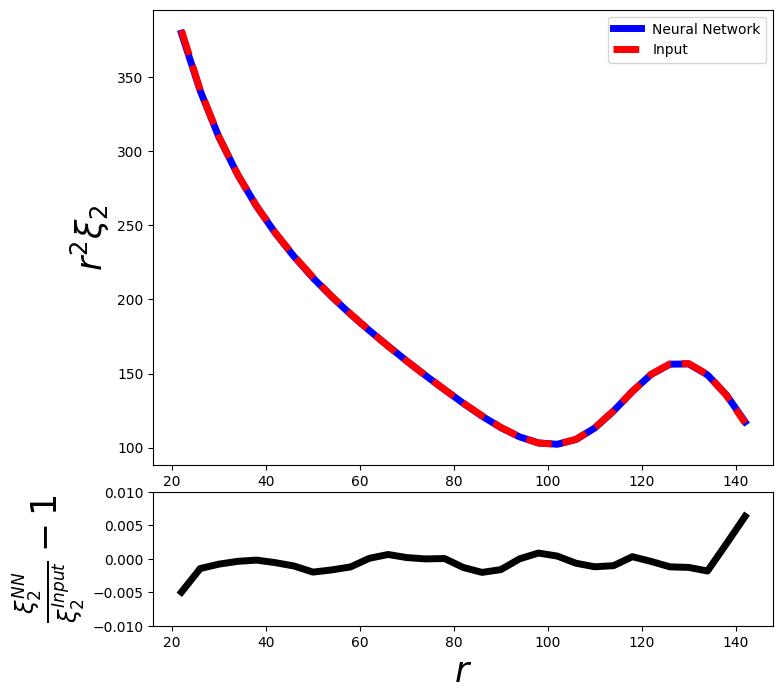

# Neural Network Basics

A neural network is a computational model inspired by the way biological neural networks in the human brain process information. It consists of interconnected nodes (neurons) organized into layers. The fundamental building blocks of a neural network are:

- **Neurons:** Each neuron receives input, processes it, and passes the output to the next layer.

- **Layers:** Neural networks are composed of:

  - Input Layer: The layer where the network receives the input data.

  - Hidden Layers: Intermediate layers where computation happens. There can be multiple hidden layers.

  - Output Layer: The final layer that produces the network's output.


- **Weights and Biases:** Connections between neurons have associated weights, and each neuron has an associated bias. These parameters are adjusted during training to minimize the error in predictions.

- **Activation Functions:** These functions introduce non-linearity into the network, allowing it to model complex relationships. Common activation functions include ReLU (Rectified Linear Unit), Sigmoid, and Tanh.


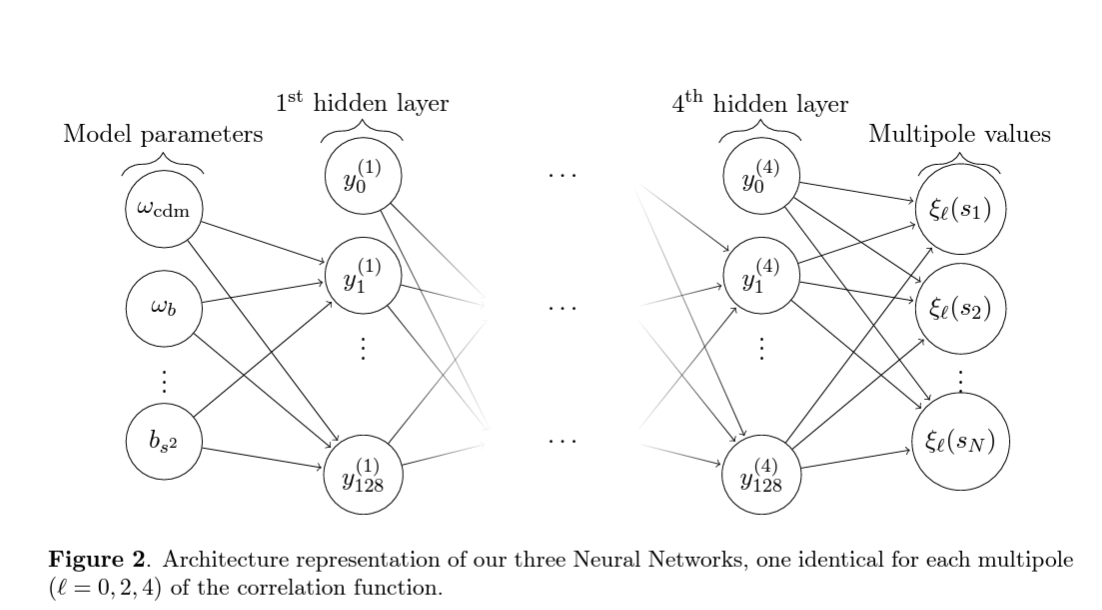

#How Neural Networks Work

- **Forward Propagation:**

  - Input data is fed into the input layer.

  - Data passes through each neuron in the hidden layers. Each neuron processes the input by applying a weighted sum of the inputs plus a bias, followed by an activation function.

  - The output of one layer becomes the input to the next layer.
This process continues until the output layer is reached, producing the final prediction.



- **Loss Calculation:**

  - The network's output is compared to the true labels using a loss function (e.g., Mean Squared Error for regression, Cross-Entropy Loss for classification).

  - The loss function measures the difference between the predicted output and the actual output.

- **Backpropagation:**

  - The loss is propagated backward through the network to update the weights and biases.

  - This involves calculating the gradient of the loss function with respect to each weight using the chain rule of calculus.

  - Gradients indicate how much each weight contributes to the loss. The weights are then adjusted in the opposite direction of the gradient to minimize the loss.
  
  

- **Gradient Descent:**

  - An optimization algorithm, such as Stochastic Gradient Descent (SGD), Adam, or RMSprop, is used to update the weights iteratively.

  - The learning rate determines the step size for each update.

- **Training:**

  - The network goes through multiple iterations (epochs) of forward propagation, loss calculation, backpropagation, and weight updates.

  - During training, the network learns to map inputs to outputs accurately by minimizing the loss.
  

## Example of a Simple Neural Network
Consider a neural network for binary classification with one hidden layer:

Input Layer: Takes in features $( x_1, x_2, \ldots, x_n )$.

Hidden Layer: Applies weights $( W_1 )$, biases $( b_1 )$, and an activation function (e.g., ReLU):

   $$
   h = \text{ReLU}(W_1 \cdot x + b_1)
   $$

Output Layer: Produces the final output using weights$( W_2 )$, biases $\ b_2 )$, and an activation function (e.g., Sigmoid for binary classification):
   $$
   \hat{y} = \sigma(W_2 \cdot h + b_2)
   $$

Loss Calculation: Uses a loss function like binary cross-entropy:
   $$
   \text{Loss} = -\frac{1}{m} \sum_{i=1}^{m} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)]
   $$

Backpropagation and Gradient Descent: Adjusts weights and biases to minimize the loss.


## Now lets prepare an emulator to reproduce the distances.
## Preparation of the data

In order to optimize the exercise, we will notice two things. Because we will assume a flat Universe, we directly have a reltion $\Omega_{\Lambda} = 1 - \Omega_m$. So we just need to move $\Omega_m$ and $H_0$. Moreover, we can note from the equation:

$$D_{com}(z_{emit})=\frac{c}{H_{0}}\int_{0}^{z_{emit}}\frac{dz}{\sqrt{\Omega_{M,0}(1+z)^{3}+\Omega_{R,0}(1+z)^{4}+\Omega_{\Lambda}}}$$

$$D_{lum}(z_{emit})=(1+z_{emit}) D_{com}(z_{emit})$$

$$D_{ang}(z_{emit})=\frac{D_{com}(z_{emit})}{1+z_{emit}}$$



In [8]:
import pandas as pd
import numpy as np


c = 299792.458
H0=68
Om_min = 0.2
Om_max = 0.4
nb_Om = 201
arr_Om = np.linspace(Om_min, Om_max, nb_Om)


z_min = 0.01
z_max = 1.7
nb_z = 170
arr_z = np.linspace(z_min, z_max, nb_z)
dz = arr_z[1] - arr_z[0]

arr_1pz3 = (1+ arr_z)**3



X = np.zeros( (len(arr_z)*len(arr_Om), 2) )
Y_com = np.zeros(len(arr_z)*len(arr_Om))
Y_lum = np.zeros(len(arr_z)*len(arr_Om))
Y_ang = np.zeros(len(arr_z)*len(arr_Om))

for ii in range(len(arr_Om)):
    arr_H_norm = np.sqrt( arr_Om[ii]*(arr_1pz3 -1) + 1.  )
    X[ii*len(arr_z) : (ii+1)*len(arr_z), 0] = arr_z
    X[ii*len(arr_z) : (ii+1)*len(arr_z), 1] = arr_Om[ii]

    com_dist_arr = np.zeros(len(arr_z))

    for jj in range(len(arr_z)):
        if jj == 0:
            com_dist_arr[jj] = c*dz/(arr_H_norm[jj]*H0)
        else:
            com_dist_arr[jj] = com_dist_arr[jj-1] + c*dz/arr_H_norm[jj]

    scaler = MinMaxScaler(feature_range=(0, 1))
    Y_com[ii * len(arr_z) : (ii + 1) * len(arr_z)] = com_dist_arr
    Y_lum[ii * len(arr_z) : (ii + 1) * len(arr_z)] = com_dist_arr * (1. + arr_z)
    Y_ang[ii * len(arr_z) : (ii + 1) * len(arr_z)] = com_dist_arr / (1. + arr_z)


###### data
data = pd.DataFrame(zip(X[:,0], X[:,1], Y_com,Y_lum,Y_ang), columns=['$z$', '$Om$', 'D_com','D_lum','D_ang'])

## Now we plot our data

Omega_m =  0.28600000000000003


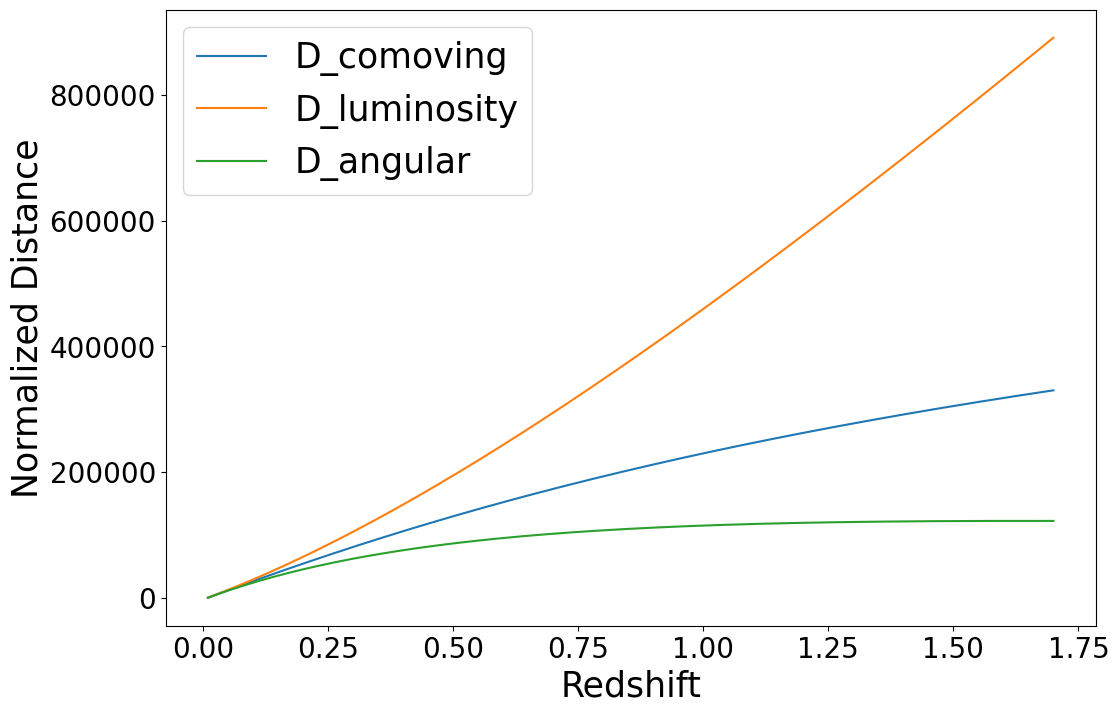

In [9]:
import matplotlib.pyplot as plt

ii = 86
print("Omega_m = ", arr_Om[ii])

H0=69.6


plt.figure(figsize=(12,8))
plt.plot( X[ii*len(arr_z) : (ii+1)*len(arr_z),0], Y_com[ii*len(arr_z) : (ii+1)*len(arr_z)], label = 'D_comoving'  )
plt.plot( X[ii*len(arr_z) : (ii+1)*len(arr_z),0], Y_lum[ii*len(arr_z) : (ii+1)*len(arr_z)], label = 'D_luminosity'  )
plt.plot( X[ii*len(arr_z) : (ii+1)*len(arr_z),0], Y_ang[ii*len(arr_z) : (ii+1)*len(arr_z)], label = 'D_angular'  )
plt.xlabel('Redshift', fontsize=25)
plt.ylabel('Normalized Distance', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc=2, fontsize=25)
plt.show()


# The error in this data will tend to increase with higher redshifts. To address this, we need to find a normalization method that effectively reduces the error values for larger redshifts.

##Normalize the data

## Plot the normalized data

## We start to create the emulator
first, we import the following libraries

In [6]:
import tensorflow.keras as K
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model

### Separate the synthetic data in trainning and validation sets

We will use a very simple version here, because the problem is very easy. So we use 80% of the data as the trainning one and the other 20% as the validation one

So we will give the X (so $\Omega_m$ and $z$ values) in input and compare the result of the only output values that will correspond to the normalized value of the distance value.

The difference between the trainning set and the validation set, is the fact we will only use the first one to fit the weights of the Neural Network. The validation set, will be used to compare the accuracy of the prediction of the Neural Network for values it never learn about.  

In [7]:
### We separate the X vector and the ascociate Y values in 80% for the trainning and 20% for the validation
#                              X_train, Y_train, X_val, Y_val


### We define the number of neurons we will use

- We need 2 neurons in input : 1 for $\Omega_m$ and 1 for $z$ values
- We will use 3 hidden layers of 100 neurons
- We need only 1 neuron in output : the value of the normalized distance.

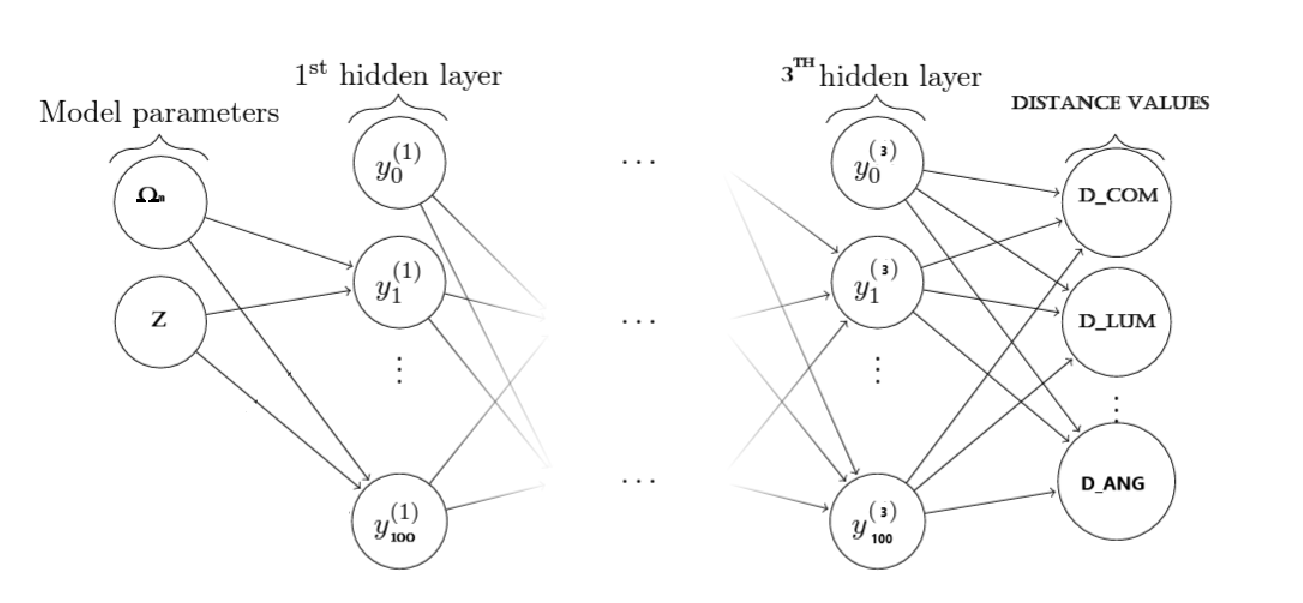

In [ ]:
# n_input debe coincidir con el número de variables independientes, atributos o columnas.
###### Para este caso n_input = 3
n_input = 2
hidden_1 = 100
hidden_2 = 100
hidden_3 = 100
# n_output debe coincidir con el número de variables
# dependientes o etiquetas o clases.
n_output = 1

### We define the architecture as Sequential and Dense.

It means that we will connect sequentially the different layers. There is no connection between neurons of a layer and another one that is just before or just after. Moreover, all neurons of a layer are connected to each neurons of the next layer.

In [ ]:
model = Sequential()

### Input layer and first hidden layer.
### This connection need to specify that the first layer we connect is the input layer.
### We specify the keyword "input_dim"
### We specify that the hidden layer 1 will use an activation function named REctified Linear Unit (RELU)

In [ ]:

model.add(K.layers.Dense(hidden_1, input_dim=n_input, activation='relu'))


### We add the Hidden layers connecting the sequentially the hidden layers 2 and 3.
### Also we define the RELU activation function

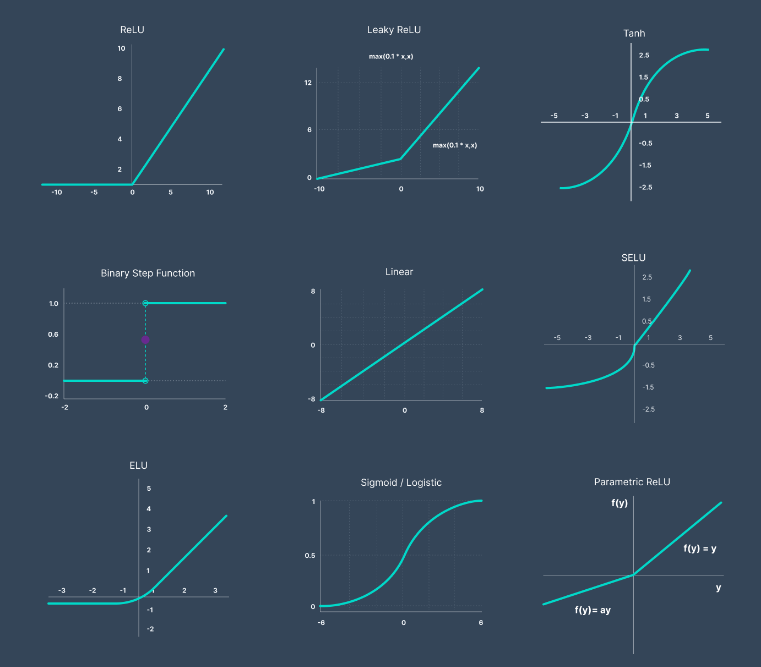

In [ ]:

model.add(K.layers.Dense(hidden_2, activation='relu'))
model.add(K.layers.Dense(hidden_3, activation='relu'))

### Output layer. As for the input layer, the outpu layer requires a specific declaration.
### In particular, the activation function is generally specific to the specific kind of answer we need.

Here we use a linear activation function, so like if there is no activation function.

In [ ]:

model.add(K.layers.Dense(n_output, activation='linear'))

### We define the function to back propagate the error over the weights

Back-propagate the error means : change layer by layer all the weights following the gradient.
So that's important to have Activation function that we can derive easily the derivative !

We do not want to fit directly the actual data, or sample of data (batch size>1) evaluated by the network. So we want to move slightly the weights and learn from the whole trainning set data.

The parameter that controle the "slightly" is the learning rate. At the beginning, we can start with larger value, allowing to move faster the weights, when we are still far from the region of interest. And then, each time the validation set stop to learn, reduce the learning rate, fitting in more details the weights.

In [ ]:
optimizer = K.optimizers.Adam(learning_rate=0.0001)

### We compile the Network

In [ ]:
# Se compila el modelo, eligiendo Optimizador y Función de pérdida.
model.compile(optimizer=optimizer, loss='mean_squared_error')


# We will play NOW !!!!!!

# How many parameters we have in this Neural Network ?

### We define the  batch size (number of data we use before to back-propagate the error).

The choice of the batch size can be important depending on the task of the network. A small batch size will extract more information from each data, but can lead to a fitting of specific informations of these data +> risk of overfitting. Using a bigger batch size will allow to capture more general features.

In [ ]:
epochs = 150
bs = 16

### We define a callback function that stop the trainning when the Network stop to learn

You can just wait for the end, so that so whole epochs finish to stop the trainning of the Network. But it is always interesting to evaluate how the Network is learning. So  you can define a number of epochs to be patient before to decide to stop. The patience is so the number of epochs for which the **loss function of validation set** will be stable or growing.

A more interesting stuff to do is to adapt the learning rate when the loss function of the validation set stoped improving. You will see thos with other tutorials during this workshop.

In [ ]:
callback = K.callbacks.EarlyStopping(monitor='loss', patience=20)

# We can start to train the Neural Network !!!!

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    epochs=epochs, batch_size=bs, callbacks=[callback])

Epoch 1/150
1709/1709 [==============================] - 8s 4ms/step - loss: 0.0069 - val_loss: 7.7950e-05
Epoch 2/150
1709/1709 [==============================] - 5s 3ms/step - loss: 4.0680e-05 - val_loss: 1.4855e-05
Epoch 3/150
1709/1709 [==============================] - 4s 2ms/step - loss: 7.3566e-06 - val_loss: 2.4131e-06
Epoch 4/150
1709/1709 [==============================] - 6s 4ms/step - loss: 1.5689e-06 - val_loss: 8.6228e-07
Epoch 5/150
1709/1709 [==============================] - 4s 2ms/step - loss: 7.3842e-07 - val_loss: 7.8680e-07
Epoch 6/150
1709/1709 [==============================] - 4s 2ms/step - loss: 5.8976e-07 - val_loss: 3.8127e-07
Epoch 7/150
1709/1709 [==============================] - 6s 3ms/step - loss: 7.4217e-07 - val_loss: 2.2929e-07
Epoch 8/150
1709/1709 [==============================] - 4s 2ms/step - loss: 5.5744e-07 - val_loss: 9.3944e-07
Epoch 9/150
1709/1709 [==============================] - 4s 2ms/step - loss: 5.7360e-07 - val_loss: 9.8017e-08
Epoch

### We plot the evolution of the trainning set and the validation set

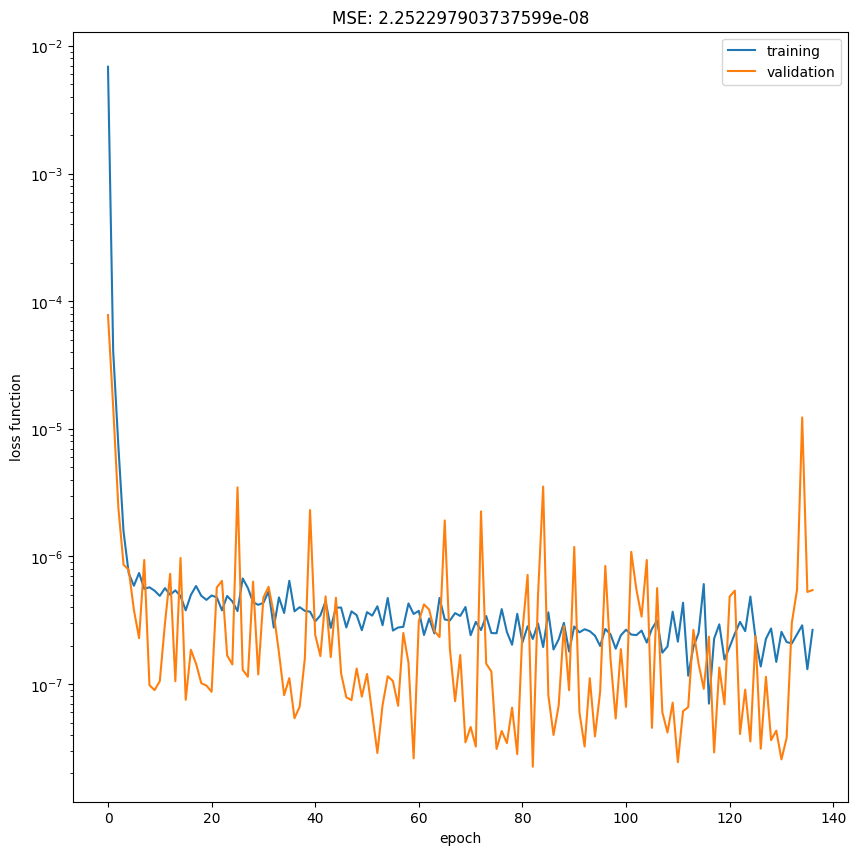

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
mse = np.min(history.history['val_loss'])
plt.title('MSE: {}'.format(mse))
plt.yscale('log')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## some comparisons

In [ ]:
ii = 100

test = np.zeros(len(arr_z))

for ii in range(len(arr_z)) :
    new_vector = np.array([arr_z[ii], arr_Om[ii]]).reshape(1,-1)
    prediction = model.predict(new_vector )
    test[ii] = prediction

1/1 [==============================] - 0s 23ms/step


<ipython-input-164-cba5d0bea560>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[ii] = prediction


1/1 [==============================] - 0s 22ms/step


## Plot the results for one point, e.g., ii = 100  (Omega_m = 0.3)

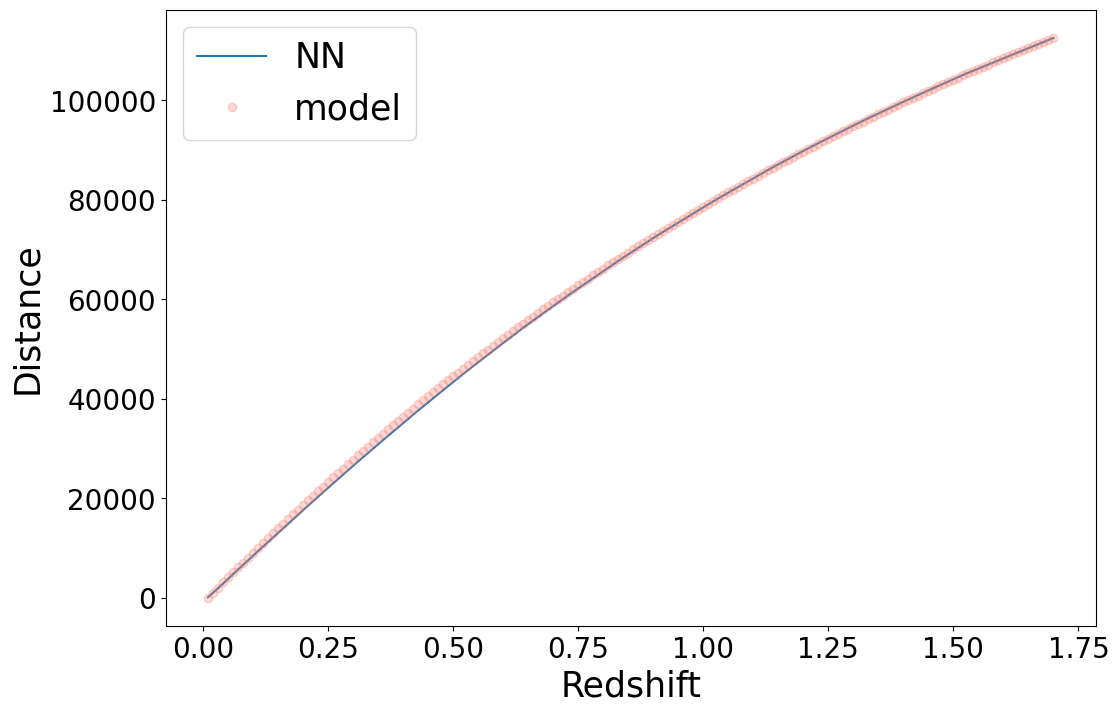

In [ ]:


plt.figure(figsize=(12,8))

plt.plot(arr_z, scaler.inverse_transform(test.reshape(-1, 1)), label = 'NN')
ii = 100 ### Omega_m = 0.3

plt.plot(arr_z, (Y_com[ii*len(arr_z) : (ii+1)*len(arr_z)]) , 'o', alpha=0.3, color='salmon', label = 'model')
plt.xlabel('Redshift', fontsize=25)
plt.ylabel('Distance', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc=2, fontsize=25)
plt.show()

## Using the normalization, get the real value of the distance

## Generalization

One of the most important achievement of the Neural Networks is the generalization, in other words, the possibility to ask for values for which we trained the Neural Networks


In [ ]:
print(model.predict(np.array([.9834, 0.2345]).reshape(1,-1)))

1/1 [==============================] - 0s 21ms/step
[[0.6775324]]


## So now, you can connect a MCMC sampler where you use the Neural Network to generate the distance modulus and fit the data

# Exercise


  - Using the emulator find the learning luminosity distance for any value.
  - The normalized modulus is defined as
     $$\mu_N = \mu_N = 5 \log_{10}\left(\frac{ D_L(z)\times H_0}{10pc}\right) =  5 \log_{10}\left(\frac{ D_L(z)}{10pc}\right) + 5 \log_{10}\left(H_0\right) $$

    so we will obtain the real distance modulus with:

$$ \mu = \mu_N - 5 \log_{10}\left(H_0\right)$$

Compute the distance modulus and find the best fit for the data from Pantheon sample which is in the github.  
